In [94]:
import pandas as pd
import glob
import os
from skbio import DistanceMatrix
from skbio.tree import nj
from ete3 import Tree, faces, TreeStyle


In [95]:
plasmo = pd.read_csv('Plasmodium.dist', header=0)
plasmo_matrix = pd.pivot_table(plasmo, values='Distnace', index='SampleA', columns='SampleB').as_matrix()
plasmo_samples = plasmo['SampleB'].unique().tolist()
jaccard_matrix = DistanceMatrix(plasmo_matrix, plasmo_samples)
newick_str = nj(jaccard_matrix, result_constructor=str)
tree = Tree(newick_str)
tree.show()

/home/shashi/miniconda/envs/bunting/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


### Exploratory data analysis

The above section plots a NJ tree from PyFinch jaccard distances. The way Jaccard distances are calculated in Bunting are as follows:
1. Between any two species if a k-mer is shared, the minimum number of shared k-mers is added to the intersection set. 
2. The maximum k-mer count between the two species is added to union set. 
3. A Jaccard distance is calculated for each of the pairwise comparisons. 

The advantage of this method is the low memory load on system. Though this system is computationally intensive, it can be massively parallelized. Thus speeding up the process. However, from the observed jaccard distances we see that the values do not correspond to the biological distance between the species. One hypothesis is that, the method is over sensitive to the differences in the size of the genome ( or k-mer diversity) . In the next section we will evaluate how we can optimize the k-mer length to normalize the k-mer diversity across the species.

In [39]:
import subprocess

In [52]:
def kanalyze(ref_path, kmer_length):
    ref_files = glob.glob('{0}/*.fasta'.format(ref_path))
    out_files = list()
    out_dir = 'ref/dkc_{0}'.format(kmer_length)
    if not os.path.exists(out_dir):
        os.mkdir(out_dir)
    for files in ref_files:
        
        out_file = 'ref/dkc_{0}/{1}.dkc'.format(kmer_length, os.path.splitext(os.path.basename(files))[0])
        if os.path.exists(out_file):
            continue
        out_files.append(out_file)
        kcmd = ['lib/kanalyze/count', '-m', 'dec', '-k', '{0}'.format(kmer_length), '-o', out_file,
                files]
        krun = subprocess.Popen(kcmd, shell=False)
        krun.wait()
    return(out_files)

In [72]:
ref_path = 'ref/fasta'
for kmer_length in range(21, 202, 10):
    kanalyze(ref_path, kmer_length)

In [73]:
from collections import defaultdict
import mmap

In [74]:
def mapcount(filename):
    f = open(filename, "r+")
    buf = mmap.mmap(f.fileno(), 0)
    lines = 0
    readline = buf.readline
    while readline():
        lines += 1
    return lines


In [81]:
import numpy as np
kmer_diversity  = list()
dkc_folder = glob.glob('ref/dkc_*')
for kfolder in dkc_folder:
    ksize = kfolder.split('_')[1]
    kfiles = glob.glob('{0}/*.dkc'.format(kfolder))
    for files in kfiles:
        species = files.split('_')[2]
        count_list = list()
        for lines in open(files):
            count_list.append(int(lines.strip().split('\t')[1]))
        mean = np.mean(count_list)
        kmer_diversity.append([species, ksize, mean])
        #kmer_diversity[species][ksize] = count
        

In [85]:
import pandas as pd
diversity_table = pd.DataFrame(kmer_diversity, columns=['Species', 'Ksize', 'MeanCount'])

In [88]:
diversity_table['Ksize'] = pd.to_numeric(diversity_table['Ksize'])
diversity_table.sort_values(by=['Ksize'], inplace=True)
diversity_table.head()

,Species,Ksize,MeanCount
142,Pgallinaceum8A,21,1.109406
132,PovalecurtisiGH01,21,1.047212
138,Pchabaudichabaudi,21,1.031228
133,PknowlesiH,21,1.094459
140,Povalewalkeri,21,1.070338


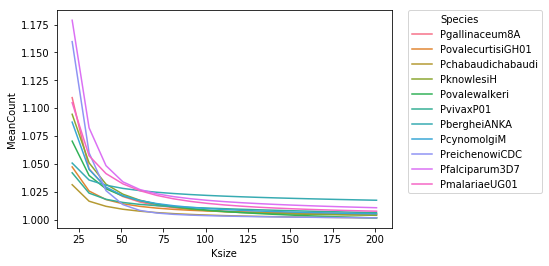

In [91]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline  

sns.lineplot(data=diversity_table, x='Ksize', y='MeanCount', hue='Species')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


In [79]:
gammas = sns.load_dataset("gammas")

In [80]:
gammas.head()

,timepoint,ROI,subject,BOLD signal
0,0.0,IPS,0,0.513433
1,0.0,IPS,1,-0.414368
2,0.0,IPS,2,0.214695
3,0.0,IPS,3,0.814809
4,0.0,IPS,4,-0.894992
